# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction import text

#words to keep: no couldnt cry not cant cannot nor except nobody off but serious enough nothing alone down only without


data = pd.read_json('./data/data.jsonl', lines=True)


def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)

    #remove stop words
    my_stop_words = text.ENGLISH_STOP_WORDS
    #print(my_stop_words)
    words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without','hereby'])
    my_stop_words = my_stop_words - words_to_keep
    
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in my_stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    return dataset

data = pre_process_data(data)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\inesc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inesc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\inesc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, s, job, position, succeed, just,...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, but, really, feel, ...",1
3,"[feeling, little, low, day]",0
4,"[beleive, sensitive, people, feeling, tend, co...",2


In [119]:
test_data = pd.read_json('./data/test.jsonl', lines=True)
train_data = pd.read_json('./data/train.jsonl', lines=True)
validation_data = pd.read_json('./data/validation.jsonl', lines=True)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)
print(test_data['text'][13])

print(test_data["text"])

['just', 'feel', 'extremely', 'comfortable', 'group', 'people', 'dont', 'need', 'hide']
0        [im, feeling, rotten, im, not, ambitious, right]
1                      [im, updating, blog, feel, shitty]
2       [make, separate, don, t, want, feel, like, m, ...
3       [left, bouquet, red, yellow, tulip, arm, feeli...
4                            [feeling, little, vain, did]
                              ...                        
1995    [just, feeling, like, unkind, doing, wrong, th...
1996    [im, feeling, little, cranky, negative, doctor...
1997    [feel, useful, people, give, great, feeling, a...
1998    [im, feeling, comfortable, derby, feel, start,...
1999    [feel, weird, meet, w, people, text, but, like...
Name: text, Length: 2000, dtype: object


# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


### TF-IDF

#### Hypertunning for tf-idf

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer




def tfidfVectorizer(data, train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words=list(my_stop_words), ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data, train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

### Hypertunning doc2vec

In [122]:
# import optuna
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# import numpy as np

# y_train = train_data['label']
# y_val = validation_data['label']

# def objective(trial):
#     vector_size = trial.suggest_int("vector_size", 50, 300)
#     window = trial.suggest_int("window", 3, 15)
#     min_count = trial.suggest_int("min_count", 1, 10)
#     epochs = trial.suggest_int("epochs", 10, 50)
    
#     # Train Doc2Vec model
#     tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]
#     doc2vec_model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
#     doc2vec_model.build_vocab(tagged_data)
#     doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
#     # Prepare document vectors for training and test sets
#     X_train_vecs  = [doc2vec_model.infer_vector(doc) for doc in train_data['text']]
#     X_val_vecs = [doc2vec_model.infer_vector(doc) for doc in validation_data['text']]
    
#     # Train Logistic Regression classifier
#     classifier = LogisticRegression(max_iter=1000)
#     classifier.fit(X_train_vecs, y_train)
    
#     # Evaluate on test set
#     y_pred = classifier.predict(X_val_vecs)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Define the study object and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters found
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Train the final model with the best hyperparameters
# best_vector_size = best_params["vector_size"]
# best_window = best_params["window"]
# best_min_count = best_params["min_count"]
# best_epochs = best_params["epochs"]

# # Train Doc2Vec model with best hyperparameters
# tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(train_data["text"])]
# best_doc2vec_model = Doc2Vec(vector_size=best_vector_size, window=best_window, min_count=best_min_count, epochs=best_epochs)
# best_doc2vec_model.build_vocab(tagged_data)
# best_doc2vec_model.train(tagged_data, total_examples=best_doc2vec_model.corpus_count, epochs=best_doc2vec_model.epochs)

# # Prepare document vectors for training and test sets with the best Doc2Vec model
# X_train_vecs  = [best_doc2vec_model.infer_vector(doc) for doc in train_data['text']]
# X_val_vecs = [best_doc2vec_model.infer_vector(doc) for doc in validation_data['text']]

# # Train Logistic Regression classifier on the final Doc2Vec vectors
# final_classifier = LogisticRegression(max_iter=1000)
# final_classifier.fit(X_train_vecs, y_train)

# # Evaluate on test set
# final_accuracy = final_classifier.score(X_val_vecs, y_val)
# print("Final accuracy on test set with the best model:", final_accuracy)


In [123]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

def train_doc2vec(train_data):
    max_epochs = 16
    vec_size = 88
    alpha = 0.025
    window = 4
    min_count = 7

    tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

    # antes tinha workers definidos
    model = Doc2Vec(vector_size=vec_size, window=window, min_count=min_count, epochs=max_epochs)
    
    model.build_vocab(tagged_data)


    model.train(tagged_data, total_examples=model.corpus_count, epochs=50)

    model.save("d2v_best_stopwords.model")
    print("Model Saved")

    return model

#train_doc2vec(train_data)

In [124]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA

def doc2vec(data, train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v_best_stopwords.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word embeddings using pre-trained models from twitter

In [125]:
from gensim.models import Word2Vec
import numpy as np
import gensim.downloader as api


def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

def text_to_mean_vector(embeddings, text):
     # split text into tokens
    tokens = text.split()

    # convert tokens to embedding vectors, up to sequence_len tokens
    total_vector = []
    i = 0
    while i < len(tokens):   # while there are tokens and did not reach desired sequence length
        try:
            total_vector.append(embeddings.get_vector(tokens[i]))
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1

    return np.mean(total_vector, axis=0)

def documents_to_vectors(embeddings, documents, sequence_len):
    vectors = []
    for doc in documents:
        vectors.append(text_to_vector(embeddings, doc, sequence_len))
    return np.array(vectors)


def documents_to_mean_vectors(embeddings, documents):
    vectors = []
    for doc in documents:
        vectors.append(text_to_mean_vector(embeddings, doc))
    return np.array(vectors)

def wordEmbeddingsVectorizer(data):
    
    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")
    
    # Initialize Word2Vec
    
    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))
    
    x_train = documents_to_vectors(model_glove_twitter, train, 40)
    x_val = documents_to_vectors(model_glove_twitter, val, 40)
    x_test = documents_to_vectors(model_glove_twitter, test, 40)
    
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])
    
    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test


def wordEmbeddingsMeanVectorizer(train_data, validation_data, test_data):

    # use twitter word embeddings
    model_glove_twitter = api.load("glove-twitter-25")

    # Initialize Word2Vec

    train = train_data['text'].apply(lambda x: ' '.join(x))
    val = validation_data['text'].apply(lambda x: ' '.join(x))
    test = test_data['text'].apply(lambda x: ' '.join(x))

    x_train = documents_to_mean_vectors(model_glove_twitter, train)
    x_val = documents_to_mean_vectors(model_glove_twitter, val)
    x_test = documents_to_mean_vectors(model_glove_twitter, test)

    # x_train = np.mean(x_train, axis=1)
    # x_val = np.mean(x_val, axis=1)
    # x_test = np.mean(x_test, axis=1)
    #
    print(x_train.shape, x_val.shape, x_test.shape)
    print(x_train[0])

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test


### Word2Vec - Word embeddings using gensim model 

### Hypertunne the word 2 vec model

In [126]:
# from gensim.models import Word2Vec
# import numpy as np
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC

# # Calculate mean for each dimension
# def calculate_mean_vectors(model, data):
#     vectors = []
#     for doc in data['text']:
#         document = []
#         for word in doc:
#             if word in model.wv:
#                 document.append(model.wv[word])
#         if document:
#             vectors.append(np.mean(document, axis=0))
#         else:
#             vectors.append(np.zeros(model.vector_size))
#     return np.array(vectors)

# def word_embeddings_vectorizer(train_data, validation_data, test_data, vector_size, window, min_count, sg):
#     data_model = Word2Vec(train_data["text"], vector_size=vector_size, window=window, min_count=min_count, sg=sg)
    
#     x_train = calculate_mean_vectors(data_model, train_data)
#     x_val = calculate_mean_vectors(data_model, validation_data)
#     x_test = calculate_mean_vectors(data_model, test_data)

#     y_train = train_data['label']
#     y_val = validation_data['label']
#     y_test = test_data['label']

#     return x_train, x_val, x_test, y_train, y_val, y_test


# def objective(trial):
#     # Define the search space for hyperparameters
#     vector_size = trial.suggest_int('vector_size', 50, 300)
#     window = trial.suggest_int('window', 2, 10)
#     min_count = trial.suggest_int('min_count', 1, 5)
#     sg = trial.suggest_categorical('sg', [0, 1])
    
#     # Call the function with the suggested hyperparameters
#     x_train, x_val, x_test, y_train, y_val, y_test = word_embeddings_vectorizer(train_data, validation_data, test_data, vector_size, window, min_count, sg)
    
#     # Train an SVC classifier
#     svc = SVC()
#     svc.fit(x_train, y_train)
    
#     # Predict on the validation set
#     y_pred = svc.predict(x_val)
    
#     # Calculate F1 score
#     f1 = f1_score(y_val, y_pred, average='weighted')  # Use weighted average for multiclass classification
    
#     return f1


# # Define your train_data, validation_data, and test_data here
# if __name__ == "__main__":
#     study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
#     study.optimize(objective, n_trials=100)  # You can adjust the number of trials as needed

#     print('Number of finished trials:', len(study.trials))
#     print('Best trial:', study.best_trial.params)
#     print('Best f1:', study.best_value)


In [127]:
from gensim.models import Word2Vec
import numpy as np

## calcular media a cada dimensão
def my_word2vec_model(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        if document:  # Check if the document is not empty
            vectors.append(np.mean(document, axis=0))  # Take the mean of word vectors for each document
        else:
            # If the document is empty, append a zero vector
            vectors.append(np.zeros(model.vector_size))
    
    return np.array(vectors)


def wordEmbeddingsVectorizer_Trained(train_data,  validation_data, test_data):

    # Hypertunning 1: 'vector_size': 120, 'window': 7, 'min_count': 3, 'sg': 1
    data_model = Word2Vec(train_data["text"], vector_size=88, window=10, min_count=2, workers=10, sg=1)
    
    x_train = my_word2vec_model(data_model, train_data)
    x_val = my_word2vec_model(data_model, validation_data)
    x_test = my_word2vec_model(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Choosing algorithm

In [128]:
# Choose vectorizer (featurizer)
#x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsMeanVectorizer(train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer_Trained(train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)


print(x_train)


(16000, 25) (2000, 25) (2000, 25)
[-0.35627666  0.37016702  0.28562868 -0.47295332 -0.5652533  -0.24137668
  0.8951466  -0.6888234  -0.95984     0.14970261 -0.6163067   0.84833336
 -3.2683165  -0.29839    -0.04744667  0.45890665  0.69503003 -0.26880667
  0.34184667 -1.4003      0.45056033  0.8567834   0.38757202  0.03085001
 -0.44497335]
[[-0.35627666  0.37016702  0.28562868 ...  0.38757202  0.03085001
  -0.44497335]
 [-0.50342786  0.43454573 -0.16875862 ... -0.11506229  0.40204158
  -0.3271286 ]
 [-0.12878944  0.47211584  0.09571286 ...  0.22633715 -0.02403856
  -0.34826428]
 ...
 [-0.29543     0.25432274 -0.47625    ... -0.1136098   0.66725004
  -0.5519062 ]
 [ 0.13759771  0.16575016 -0.28576857 ...  0.19519714  0.24859715
  -0.20122172]
 [ 0.32407427  0.22217628 -0.04563797 ... -0.06199572  0.15046288
  -0.57057285]]


### Lexicons

In [129]:
from nrclex import NRCLex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

lexicon_emotions = ['fear','anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'anticipation']

def get_features(data):
    features = []
    for text in data['text']:
        text = ' '.join(text)
        text = NRCLex(text)
        features.append([text.affect_frequencies.get(emotion, 0) for emotion in lexicon_emotions])
    return features

# text_object = NRCLex(text='I am nervous')
# print(text_object.affect_frequencies)
# print(text_object.affect_dict)
# print(text_object.top_emotions)
# print(text_object.affect_list)
# print(text_object.raw_emotion_scores)
# print(text_object.lexicon)


def lexiconVectorizer(train_data, validation_data, test_data):
    x_train = get_features(train_data)
    x_val = get_features(validation_data)
    x_test = get_features(test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

In [130]:
# Choose vectorizer (featurizer)
#x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer(data)
x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)
x_train_lexicon, x_val_lexicon, x_test_lexicon, y_train, y_val, y_test = lexiconVectorizer(train_data, validation_data, test_data)

In [131]:
# join the features
# import numpy as np

x_train = np.concatenate((x_train, x_train_lexicon), axis=1)
x_val = np.concatenate((x_val, x_val_lexicon), axis=1)
x_test = np.concatenate((x_test, x_test_lexicon), axis=1)


### Apply SMOTE

In [132]:
## Apply SMOTE
import numpy as np
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=4, sampling_strategy='auto', k_neighbors=18)
x_train, y_train = smote.fit_resample(x_train, y_train)

#### Hypertunning number of features (using PCA) for each model

In [133]:
# import optuna
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
# import lightgbm as lgb

# def objective(trial):
#     # Define parameters to search
#     n_components = trial.suggest_int('n_components', 2, 25)
    
#     # Define the pipeline with PCA and a classifier
#     pipeline = Pipeline([
#         ('pca', PCA(n_components=n_components)),
#         #('clf', SVC())
#         ('clf', lgb.LGBMClassifier())
#         #('clf', LogisticRegression())
#     ])

#     # Fit the pipeline
#     pipeline.fit(x_train, y_train)
    
#     # Evaluate on the validation set
#     y_pred = pipeline.predict(x_val)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Optimize hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters found
# best_params = study.best_params

# # Get the best model
# best_n_components = best_params['n_components']
# best_model = Pipeline([
#     ('pca', PCA(n_components=best_n_components)),
#     ('clf', )  
# ])
# best_model.fit(x_train, y_train)

# # Use the best model for prediction
# y_pred = best_model.predict(x_test)

# # Evaluate the best model
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

##### Model hypertunning

In [134]:
# import optuna
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# # Define objective function for Optuna
# def objective(trial):
#     # Define solver
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
#     if solver == 'lbfgs':
#         penalty = 'l2'  # LBFGS only supports L2 penalty
#     else:
#         penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
#     C = trial.suggest_loguniform('C', 0.01, 10)
    
#     # Instantiate Logistic Regression classifier with hyperparameters
#     logreg_classifier = LogisticRegression(max_iter=1000, solver=solver, penalty=penalty, C=C)
    
#     # Train classifier
#     logreg_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = logreg_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

##### Model Training

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# pca = PCA(n_components=77)
# x_train = pca.fit_transform(x_train)
# x_val = pca.transform(x_val)
# x_test = pca.transform(x_test)

logreg_classifier = LogisticRegression(solver='liblinear', penalty='l2', C=0.03784347512520397)
logreg_classifier.fit(x_train, y_train)
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.819
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       550
           1       0.93      0.84      0.88       704
           2       0.63      0.78      0.70       178
           3       0.81      0.77      0.79       275
           4       0.70      0.78      0.74       212
           5       0.52      0.74      0.61        81

    accuracy                           0.82      2000
   macro avg       0.75      0.80      0.77      2000
weighted avg       0.83      0.82      0.82      2000

[[471   8  13  22  25  11]
 [ 12 589  53  14  18  18]
 [  9  18 139   4   5   3]
 [ 19  11   5 213  18   9]
 [ 12   4   7   9 166  14]
 [  7   5   2   2   5  60]]


## SVM


##### Hypertunning

In [136]:
# import optuna
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# def objective(trial):
#     # Define kernel
#     kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
#     # For 'poly', 'rbf', and 'sigmoid' kernels, suggest degree parameter
#     if kernel in ['poly', 'rbf', 'sigmoid']:
#         degree = trial.suggest_int('degree', 2, 5)
#     else:
#         degree = 3  # Default degree value for kernels that don't use it
    
#     # Instantiate SVM classifier with hyperparameters
#     svm_classifier = SVC(kernel=kernel, degree=degree)
    
#     # Train classifier
#     svm_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = svm_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

# #[I 2024-04-01 12:39:28,014] Trial 36 finished with value: 0.8245 and parameters: {'kernel': 'poly', 'degree': 2}. Best is trial 36 with value: 0.8245.


### Training

In [137]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='poly', degree=2, random_state=42)
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.836
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       550
           1       0.90      0.87      0.89       704
           2       0.70      0.72      0.71       178
           3       0.82      0.80      0.81       275
           4       0.75      0.76      0.76       212
           5       0.64      0.73      0.68        81

    accuracy                           0.84      2000
   macro avg       0.78      0.80      0.79      2000
weighted avg       0.84      0.84      0.84      2000

Confusion Matrix:
 [[488  13   5  18  22   4]
 [ 17 614  41  14   8  10]
 [ 11  25 129   6   5   2]
 [ 23  13   2 220  11   6]
 [ 17   9   5   8 162  11]
 [  4   8   1   2   7  59]]


## KNN

##### Hypertunning

In [138]:
# import optuna
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
#     algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    
#     # Instantiate KNN classifier with hyperparameters
#     knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    
#     # Train classifier
#     knn_classifier.fit(x_train, y_train)
    
#     # Predict on validation set
#     y_pred = knn_classifier.predict(x_val)
    
#     # Calculate accuracy score
#     accuracy = accuracy_score(y_val, y_pred)
    
#     return accuracy

# # Create Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get best hyperparameters
# best_params = study.best_params

# print(best_params)

# # [I 2024-04-01 13:53:46,403] Trial 26 finished with value: 0.701 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 26 with value: 0.701.

In [139]:
from sklearn.neighbors import KNeighborsClassifier

#knn_classifier = KNeighborsClassifier(n_neighbors=5)
hyperparameters = {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}
knn_classifier = KNeighborsClassifier(**hyperparameters)
knn_classifier.fit(x_train, y_train)
y_pred = knn_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6935
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76       550
           1       0.87      0.69      0.77       704
           2       0.44      0.68      0.53       178
           3       0.65      0.67      0.66       275
           4       0.57      0.67      0.61       212
           5       0.39      0.77      0.52        81

    accuracy                           0.69      2000
   macro avg       0.62      0.70      0.64      2000
weighted avg       0.74      0.69      0.71      2000

Confusion Matrix:
 [[390  15  27  56  37  25]
 [ 31 488 106  23  30  26]
 [ 12  23 121   4   9   9]
 [ 22  19  11 185  27  11]
 [ 14  10   8  14 141  25]
 [  4   3   4   3   5  62]]


### Boosting Algorithms

Testing with some boosting algorithms

##### XGBOOST

In [140]:
import xgboost as xgb
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train, y_train)
y_pred_xgb = xgb_classifier.predict(x_val)

# Evaluate the performance for XGBoost
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

# Print the evaluation metrics for XGBoost
print("XGBoost Classifier Evaluation:")
print("Accuracy:", accuracy_xgb)
print("Classification Report:\n", report_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

XGBoost Classifier Evaluation:
Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       550
           1       0.83      0.90      0.86       704
           2       0.73      0.58      0.65       178
           3       0.83      0.67      0.74       275
           4       0.75      0.71      0.73       212
           5       0.68      0.54      0.60        81

    accuracy                           0.80      2000
   macro avg       0.77      0.71      0.74      2000
weighted avg       0.80      0.80      0.80      2000

Confusion Matrix:
 [[486  26   7  14  14   3]
 [ 26 631  30   7   8   2]
 [ 15  52 104   2   4   1]
 [ 44  25   1 184  17   4]
 [ 25  12   0  13 151  11]
 [ 14  13   0   3   7  44]]


##### Lightgbm

In [141]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train, y_train)
y_pred_lgb = lgb_classifier.predict(x_val)

# Evaluate the performance for LightGBM
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
report_lgb = classification_report(y_val, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)

# Print the evaluation metrics for LightGBM
print("\nLightGBM Classifier Evaluation:")
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", report_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24988
[LightGBM] [Info] Number of data points in the train set: 32172, number of used features: 98
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM Classifier Evaluation:
Accuracy: 0.8045
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83       550
           1       0.84      0.90      0.87       704
           2       0.75      0.58      0.65       178
           3       0.85      0.68      0.75       275
           4       0.75      0.72      0.

In [142]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(x_train, y_train)
y_pred_adaboost = adaboost_classifier.predict(x_val)

# Evaluate the performance for AdaBoost
accuracy_adaboost = accuracy_score(y_val, y_pred_adaboost)
report_adaboost = classification_report(y_val, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_val, y_pred_adaboost)

# Print the evaluation metrics for AdaBoost
print("AdaBoost Classifier Evaluation:")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:\n", report_adaboost)
print("Confusion Matrix:\n", conf_matrix_adaboost)


AdaBoost Classifier Evaluation:
Accuracy: 0.679
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.75       550
           1       0.80      0.77      0.78       704
           2       0.57      0.52      0.54       178
           3       0.58      0.49      0.53       275
           4       0.48      0.66      0.55       212
           5       0.46      0.54      0.50        81

    accuracy                           0.68      2000
   macro avg       0.61      0.62      0.61      2000
weighted avg       0.69      0.68      0.68      2000

Confusion Matrix:
 [[408  40   8  38  43  13]
 [ 41 540  47  33  30  13]
 [ 19  44  93   6  14   2]
 [ 47  23  12 134  52   7]
 [ 22  15   3  17 139  16]
 [  8  12   1   4  12  44]]


###  Bagging Algorithm

In [143]:
# from sklearn.ensemble import BaggingClassifier, VotingClassifier

# model1 = xgb_classifier
# model2 = svm_classifier
# model3 = logreg_classifier

# voting_clf = VotingClassifier(estimators=[
#     ('model1', model1), 
#     ('model2', model2),
#     ('model3', model3)
# ], voting='soft')
# # Fit the ensemble model
# voting_clf.fit(x_train, y_train)

# # Predict the validation set
# y_pred_voting = voting_clf.predict(x_val)

# # Evaluate the performance for the ensemble model
# accuracy_voting = accuracy_score(y_val, y_pred_voting)
# report_voting = classification_report(y_val, y_pred_voting)
# conf_matrix_voting = confusion_matrix(y_val, y_pred_voting)

# # Print the evaluation metrics for the ensemble model
# print("Voting Classifier Evaluation:")
# print("Accuracy:", accuracy_voting)
# print("Classification Report:\n", report_voting)
# print("Confusion Matrix:\n", conf_matrix_voting)


# 5. Model Evaluation

In [144]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_logreg = logreg_classifier.predict(x_test)

0.7995
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       581
           1       0.91      0.79      0.84       695
           2       0.55      0.80      0.65       159
           3       0.77      0.77      0.77       275
           4       0.77      0.74      0.75       224
           5       0.39      0.77      0.52        66

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.83      0.80      0.81      2000

[[494  14  13  31  15  14]
 [  9 550  82  11  15  28]
 [  4  18 127   3   0   7]
 [ 16  12   7 212  16  12]
 [ 16   6   1  16 165  20]
 [  1   7   1   2   4  51]]


In [145]:
# y_pred = mnb_classifier.predict(x_test)
# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

In [146]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.8195
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       581
           1       0.89      0.85      0.87       695
           2       0.64      0.75      0.69       159
           3       0.78      0.74      0.76       275
           4       0.78      0.75      0.77       224
           5       0.48      0.71      0.58        66

    accuracy                           0.82      2000
   macro avg       0.74      0.78      0.76      2000
weighted avg       0.83      0.82      0.82      2000

[[509  15   7  28  17   5]
 [ 16 591  54   8   9  17]
 [  6  25 120   4   2   2]
 [ 25  16   5 203  16  10]
 [ 15   9   1  14 169  16]
 [  4  10   0   2   3  47]]


In [147]:
y_pred = xgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.794
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       581
           1       0.81      0.88      0.84       695
           2       0.70      0.60      0.65       159
           3       0.77      0.68      0.72       275
           4       0.72      0.71      0.72       224
           5       0.57      0.44      0.50        66

    accuracy                           0.79      2000
   macro avg       0.74      0.70      0.71      2000
weighted avg       0.79      0.79      0.79      2000

[[507  32   3  20  16   3]
 [ 24 609  33  12  11   6]
 [ 10  47  96   3   2   1]
 [ 31  26   5 188  20   5]
 [ 21  17   1  19 159   7]
 [  5  18   0   2  12  29]]


In [148]:
y_pred = lgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.785
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       581
           1       0.81      0.88      0.84       695
           2       0.70      0.62      0.65       159
           3       0.76      0.65      0.70       275
           4       0.73      0.68      0.70       224
           5       0.58      0.44      0.50        66

    accuracy                           0.79      2000
   macro avg       0.73      0.69      0.71      2000
weighted avg       0.78      0.79      0.78      2000

[[501  35   5  23  14   3]
 [ 25 610  32   9  12   7]
 [  9  44  98   5   2   1]
 [ 37  34   5 180  17   2]
 [ 32  14   1  17 152   8]
 [  7  16   0   3  11  29]]


In [149]:
y_pred = adaboost_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.658
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       581
           1       0.77      0.74      0.76       695
           2       0.48      0.52      0.50       159
           3       0.58      0.45      0.51       275
           4       0.52      0.65      0.58       224
           5       0.35      0.42      0.39        66

    accuracy                           0.66      2000
   macro avg       0.57      0.58      0.57      2000
weighted avg       0.66      0.66      0.66      2000

[[419  44  20  41  45  12]
 [ 55 517  58  26  24  15]
 [ 18  39  82   7   9   4]
 [ 55  42  10 124  38   6]
 [ 34  15   1  14 146  14]
 [  7  11   1   1  18  28]]


In [150]:
y_pred = knn_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.692
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       581
           1       0.86      0.67      0.75       695
           2       0.39      0.71      0.51       159
           3       0.65      0.67      0.66       275
           4       0.63      0.67      0.65       224
           5       0.32      0.79      0.46        66

    accuracy                           0.69      2000
   macro avg       0.62      0.70      0.63      2000
weighted avg       0.75      0.69      0.71      2000

[[423  19  36  45  33  25]
 [ 27 463 115  24  23  43]
 [  4  16 113  11   6   9]
 [ 26  23  12 184  22   8]
 [ 16   8  10  17 149  24]
 [  0   7   1   2   4  52]]


# 6. Cause of errors


In [151]:
emotions_to_int = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

int_to_emotions = {v: k for k, v in emotions_to_int.items()}


wrong_predictions = y_test[y_test != y_pred_logreg].index
for i, index in enumerate(wrong_predictions):
    if i == 10:
        break
    print(test_data['text'][index])
    print('Real: ', int_to_emotions[test_data['label'][index]])
    print('Pred:', int_to_emotions[y_pred_logreg[index]])
    print('\n')



['make', 'separate', 'don', 't', 'want', 'feel', 'like', 'm', 'ashamed']
Real:  sadness
Pred: fear


['explain', 'clung', 'relationship', 'boy', 'way', 'immature', 'uncommitted', 'despite', 'excitement', 'feeling', 'getting', 'accepted', 'master', 'program', 'university', 'virginia']
Real:  joy
Pred: love


['jest', 'feel', 'grumpy', 'tired', 'pre', 'menstrual', 'probably', 'but', 'only', 'week', 'im', 'fit', 'walrus', 'vacation', 'summer']
Real:  anger
Pred: joy


['don', 't', 'feel', 'particularly', 'agitated']
Real:  fear
Pred: anger


['feel', 'just', 'bcoz', 'fight', 'mad', 'n', 'u', 'wan', 'na', 'make', 'publicity', 'n', 'let', 'world', 'know', 'fight']
Real:  anger
Pred: surprise


['im', 'not', 'sure', 'feeling', 'loss', 'away', 'but', 'dull', 'sweet', 'feeling', 'nostalgia', 'shared', 'life', 'dad', 'luck', 'dad', 'year']
Real:  sadness
Pred: surprise


['survey', 'post', 'year', 'only', 'feel', 'pleased', 'vague', 'snippet', 'only', 'feel', 'little', 'bit', 'capture', 'like',

In [152]:
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

[[494  14  13  31  15  14]
 [  9 550  82  11  15  28]
 [  4  18 127   3   0   7]
 [ 16  12   7 212  16  12]
 [ 16   6   1  16 165  20]
 [  1   7   1   2   4  51]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       581
           1       0.91      0.79      0.84       695
           2       0.55      0.80      0.65       159
           3       0.77      0.77      0.77       275
           4       0.77      0.74      0.75       224
           5       0.39      0.77      0.52        66

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.83      0.80      0.81      2000



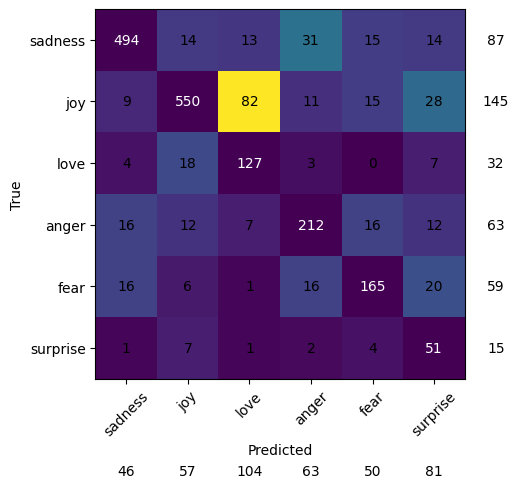

In [153]:
# check which emotions are being confused
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
    
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
# annotate the axes with the emotion names
plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
# add colorbar more to the right
# plt.colorbar()
# legend the axes with predicted and true values
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, conf_matrix_copy[i, j], ha='center', va='center', color='white')
        else:
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

for i in range(conf_matrix.shape[0]): # this does not count correct predictions
    plt.text(6, i, conf_matrix[i, :].sum(), ha='center', va='center', color='black')
for i in range(conf_matrix.shape[1]):
    plt.text(i, 7, conf_matrix[:, i].sum(), ha='center', va='center', color='black')
plt.show()

The test set appears to be unbalance.
- 'joy' is a lot more mixed with 'love' than the contrary. 
- 'surprise' has a low Precision

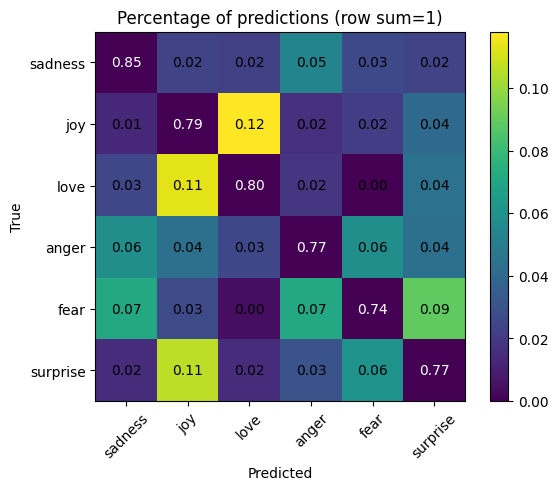

In [154]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, None] # normalize the confusion matrix
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')

plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, f'{conf_matrix_copy[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            plt.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center', color='black')

        
plt.title('Percentage of predictions (row sum=1)')
# Rows add to 1
plt.show()



- sadness mixed with joy and anger
- joy mixed with love
- love mixed with joy
- anger mixed with sadness and joy??
- fear mixed with sadness
- surprise mixed with almost everything

# 7. Experiment with user-inputed setences

In [155]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text

emotions = {
    0: "0. sadness",
    1: "1. joy",
    2: "2. love",
    3: "3. anger",
    4: "4. fear",
    5: "5. surprise"
}

def preprocess_text(phrase):
    # Tokenize
    tokens = nltk.word_tokenize(phrase.lower())

    # Remove stop words
    my_stop_words = set(stopwords.words('english'))
    words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without','hereby'])
    my_stop_words -= words_to_keep
    tokens = [word for word in tokens if word not in my_stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

def doc2vec_text(tokens):
    model = Doc2Vec.load("d2v_best_stopwords.model")
    return model.infer_vector(tokens)

def classify_emotion(number):
    if number==0:
        return "0. sadness"
    if number==1:
        return "1. joy"
    if number==2:
        return "2. love"
    if number==3:
        return "3. anger"
    if number==4:
        return "4. fear"
    if number==5:
        return "5. surprise"

    return "Not possible to identify"


def analyze_sentiment(phrase):
    tokens = preprocess_text(phrase)
    tokens_embeddings = doc2vec_text(tokens)

    # Reshape to have proper structure
    tokens_embeddings = np.array(tokens_embeddings).reshape(1, -1)

    # Predict the class using the SVM classifier
    predicted_class = svm_classifier.predict(tokens_embeddings)
    print(classify_emotion(predicted_class[0]))


In [157]:
#phrase = "i love love"
#analyze_sentiment(phrase)

ValueError: X has 88 features, but SVC is expecting 99 features as input.